In [1]:
import os
os.chdir("/content/drive/MyDrive/DataScience/PROJECT/2022_Time_Series/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
with open('data/pv_imputation.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [6]:
x_features = ['alt', 'azi', 'rad', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']

x_scaler = MinMaxScaler()
x_scaler.fit(pv[x_features])
pv[x_features] = x_scaler.transform(pv[x_features])

In [7]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,24,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,14,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

pv_val_criterion = pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]
pv_test_criterion = pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]

In [8]:
pv_train[['power']].isnull().sum()

power    0
dtype: int64

# model

In [18]:
!pip install pytorch_tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from pytorch_tabnet.tab_model import TabNetRegressor

In [26]:
clf = TabNetRegressor()
clf.fit(np.array(pv_train[x_features]), np.array(pv_train[['power']]),
        eval_set=[(np.array(pv_val[x_features]), np.array(pv_val[['power']]))],
        patience=10) # eval_set=[(X_valid, y_valid)]
  

val_pred = clf.predict(np.array(pv_val[x_features]))
test_pred = clf.predict(np.array(pv_test[x_features]))

Device used : cuda
epoch 0  | loss: 57007.44304| val_0_mse: 48588.23343|  0:00:00s
epoch 1  | loss: 52851.78262| val_0_mse: 44738.71257|  0:00:01s
epoch 2  | loss: 47430.66841| val_0_mse: 41215.95032|  0:00:02s
epoch 3  | loss: 41305.07909| val_0_mse: 33241.01074|  0:00:02s
epoch 4  | loss: 34504.43882| val_0_mse: 39883.45261|  0:00:03s
epoch 5  | loss: 27793.87685| val_0_mse: 35597.94764|  0:00:03s
epoch 6  | loss: 21459.95968| val_0_mse: 26637.051|  0:00:03s
epoch 7  | loss: 15602.43877| val_0_mse: 24775.07086|  0:00:04s
epoch 8  | loss: 10693.07407| val_0_mse: 24248.79302|  0:00:04s
epoch 9  | loss: 8549.8932| val_0_mse: 11771.54232|  0:00:04s
epoch 10 | loss: 5879.72884| val_0_mse: 12944.29319|  0:00:05s
epoch 11 | loss: 5283.82235| val_0_mse: 12126.81144|  0:00:05s
epoch 12 | loss: 5216.01511| val_0_mse: 8678.6657|  0:00:05s
epoch 13 | loss: 5352.13049| val_0_mse: 9987.96256|  0:00:06s
epoch 14 | loss: 5311.35587| val_0_mse: 11548.13699|  0:00:06s
epoch 15 | loss: 5152.56198| val_

In [27]:
pv_val_criterion['pred'] = val_pred[24*7:].reshape(-1)
pv_test_criterion['pred'] = test_pred[24*7:].reshape(-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

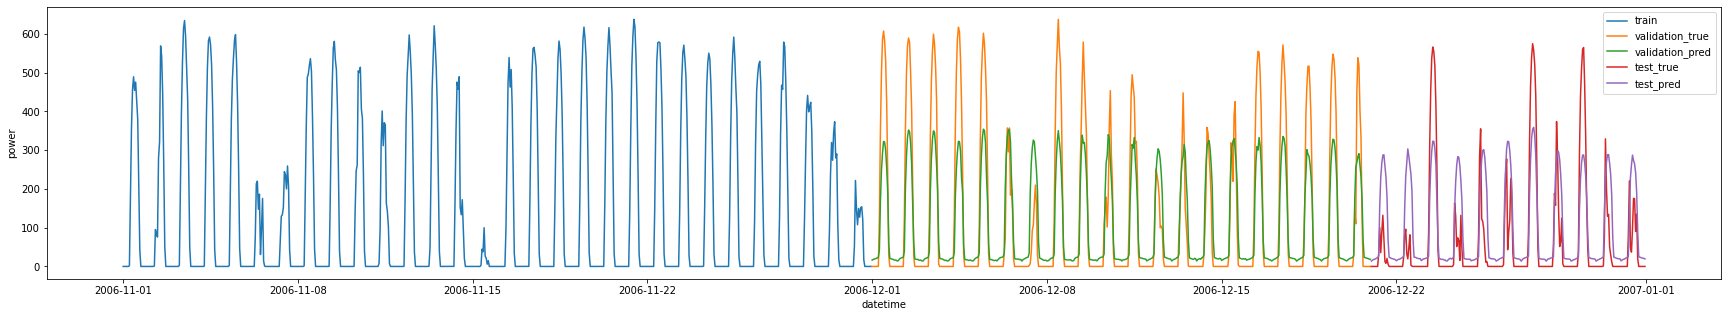

In [28]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [29]:
print(f"validation MSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"validation MSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation MSE: 9202.26344
validation R2: 0.74360
validation MSE: 10502.09663
validation R2: 0.45569
